In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import prophet as fbpro

import warnings
warnings.filterwarnings("ignore")


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
''' 
Amazon Stock Dataset (2015-2024)
'''

df = pd.read_csv('AMZN.csv')
df.head()



,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-26,15.5910,15.6500,15.376000,15.4830,15.4830,63394000
1,2015-01-27,15.3150,15.5120,15.131500,15.3375,15.3375,58406000
2,2015-01-28,15.4905,15.5755,15.190000,15.1955,15.1955,61276000
3,2015-01-29,15.2365,15.6400,14.966500,15.5890,15.5890,173132000
4,2015-01-30,17.3160,17.9750,17.037001,17.7265,17.7265,477122000


In [3]:

df.isnull().sum()     


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
"""  
Prophet requires specific column names
Prophet only works if the dataframe has exactly:

ds → Date column (time series index)
y → Target column (value you want to forecast)

So you’re renaming Date → ds and Adj Close → y.
"""

df[['ds', 'y']] = df[['Date', 'Adj Close']]

# Keep only the required columns
df = df[['ds', 'y']]
df['ds'] = pd.to_datetime(df['ds'])
df.head()



,ds,y
0,2015-01-26,15.4830
1,2015-01-27,15.3375
2,2015-01-28,15.1955
3,2015-01-29,15.5890
4,2015-01-30,17.7265


In [5]:

'''  
Now, we split the data frame into train and test data, we will be using 
7 years of data for training and a  2 year of data for test purpose
'''

# split data frame  into two parts train and test

split_date = "2022-10-20"
df_train = df.loc[df.ds <= split_date].copy()
df_test = df.loc[df.ds > split_date].copy()

In [6]:

'''  
Now, we instantiate the Facebook prophet API, this prophet API works similar to scikit-learn.
It uses the fit function to fit the dataset into the model and predict function to forecast 
future values.
'''

# intiate prophet

model = fbpro.Prophet()

# fit training data
model.fit(df_train)




00:12:35 - cmdstanpy - INFO - Chain [1] start processing
00:12:36 - cmdstanpy - INFO - Chain [1] done processing


In [7]:

# Forecast on test set (backtesting)
forecast_test = model.predict(df_test)
print(forecast_test.tail())     

            ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
311 2024-01-19  75.971136   44.629698  103.822640    47.317151   104.895571   
312 2024-01-22  75.674260   43.713455  102.853452    46.931826   104.620945   
313 2024-01-23  75.575301   43.986092  103.426597    46.744418   104.539983   
314 2024-01-24  75.476343   42.453252  102.747855    46.557011   104.544514   
315 2024-01-25  75.377384   42.555513  103.934307    46.369603   104.558915   

     additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
311       -1.987786             -1.987786             -1.987786  0.385373   
312       -2.152258             -2.152258             -2.152258  0.526752   
313       -2.078921             -2.078921             -2.078921  0.641329   
314       -2.009916             -2.009916             -2.009916  0.718834   
315       -2.072666             -2.072666             -2.072666  0.631593   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearl

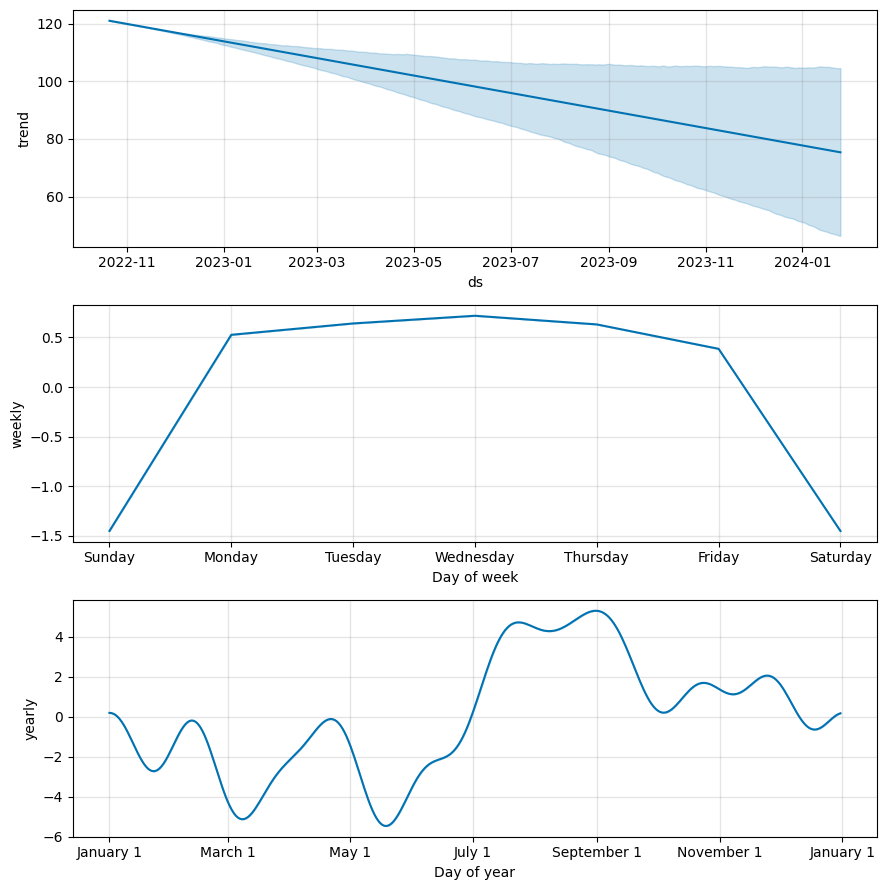

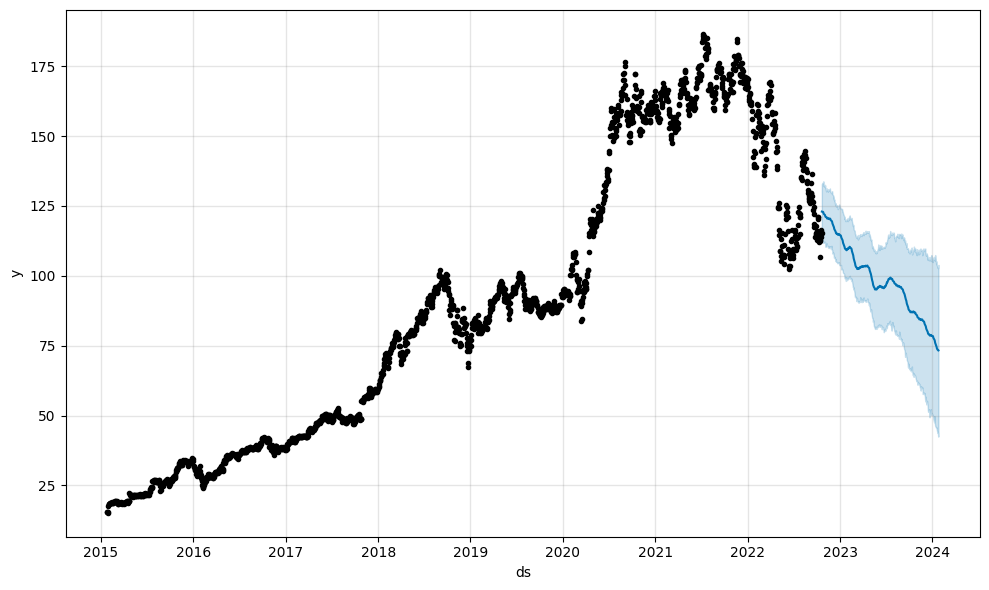

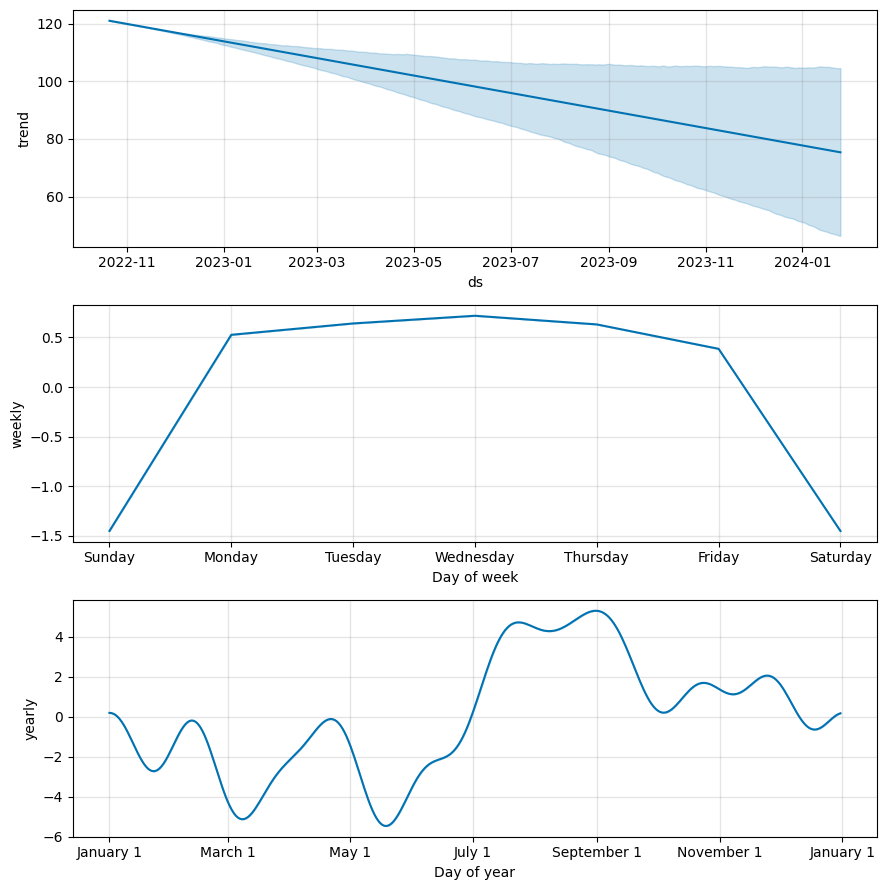

In [8]:
'''  
As we can see this column contains the date column, predict share price (y_hat),
lower and upper estimates of it, trend components, seasonal components (weekly and yearly).
'''

# Plot test forecast
model.plot(forecast_test)
model.plot_components(forecast_test)


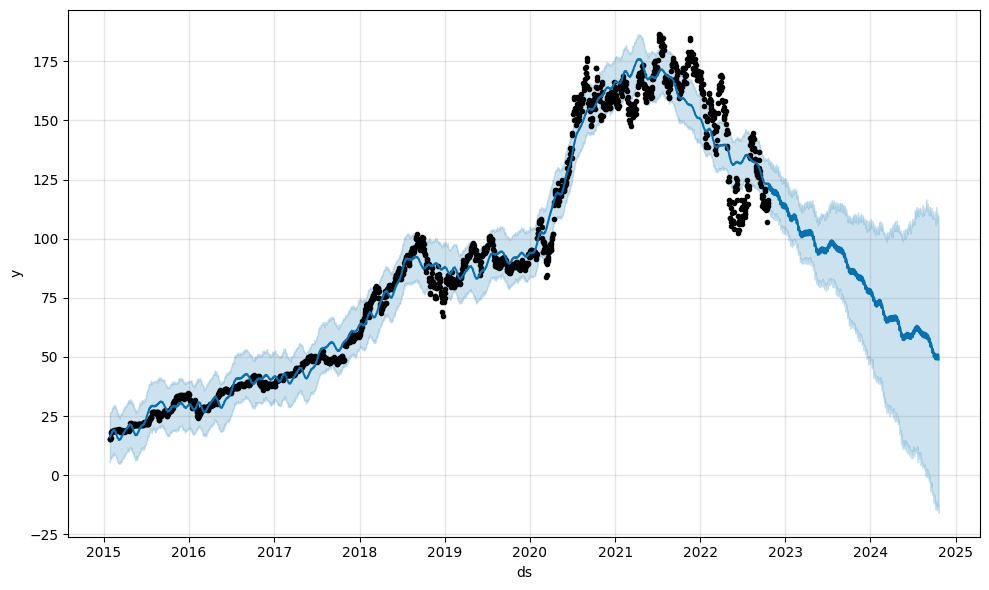

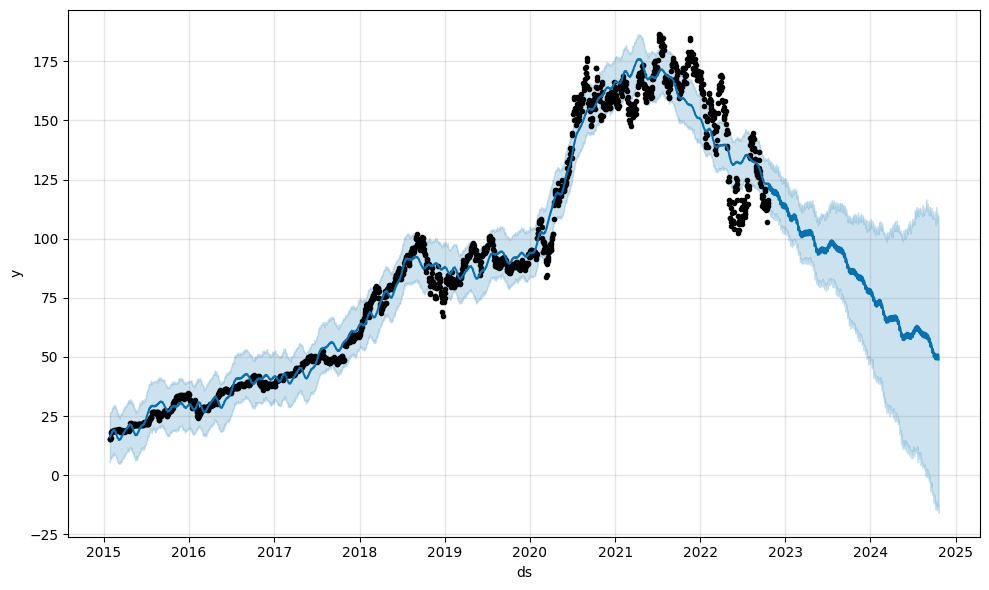

In [9]:
#  Forecast into the future (like ,  2 years ahead)
future = model.make_future_dataframe(periods=730)  # 730 days ≈ 2 years
forecast_future = model.predict(future)

# Plot future forecast
model.plot(forecast_future)

In [10]:

from sklearn.metrics import mean_squared_error, mean_absolute_error


# 1. Forecast on test set
forecast_test = model.predict(df_test)

# 2. Define evaluation metrics
def mean_absolute_percentage_error(y_true, y_pred):
    """Safe MAPE: ignores zero values in y_true"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def smape(y_true, y_pred):
    """Symmetric MAPE: handles zero values safely"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

# 3. Calculate metrics
mse  = mean_squared_error(df_test["y"], forecast_test["yhat"])
mae  = mean_absolute_error(df_test["y"], forecast_test["yhat"])
mape = mean_absolute_percentage_error(df_test["y"], forecast_test["yhat"])
smap = smape(df_test["y"], forecast_test["yhat"])

# 4. Print results
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Symmetric MAPE (SMAPE): {smap:.2f}%")


Mean Squared Error (MSE): 1494.98
Mean Absolute Error (MAE): 32.14
Mean Absolute Percentage Error (MAPE): 25.44%
Symmetric MAPE (SMAPE): 28.90%


In [ ]:
"""   
Interpretation of  Results

MSE = 1494.98
→ Large number, but not very interpretable directly (since it’s squared error).

MAE = 32.14
→ On average, Prophet is off by $32 per share in the test period.

MAPE = 25.44%
→ Predictions are, on average, 25% away from the actual value.
→ This is a bit high — typically for financial models, you’d want <10–15%.

SMAPE = 28.90%
→ Confirms the MAPE result; symmetric version shows similar error.

What this means

Prophet is capturing the general trend, but struggling with short-term fluctuations (very common with stock data).

Stock prices are highly volatile and influenced by external shocks → Prophet (trend + seasonality) can only go so far.


Next Steps

If  want to reduce that ~25% error:

Tune Prophet hyperparameters (changepoint_prior_scale, seasonality_prior_scale)

Add regressors (like market indices, macroeconomic factors, or trading volume)

Try ensemble approaches (Prophet + XGBoost / LSTM)

"""


'  \nWhat this means\n\nMAE = 5.71\nOn average, the model’s forecast is off by about 5.7 units (dollars if your stock price is in USD).\n→ Easy to interpret: "The model misses by ~$5.7 per day on average."\n\nMSE = 62.57\nThe average of the squared errors.\nSince squaring exaggerates big mistakes, a few large errors could push MSE higher.\n\nIf you want the error back in the same units as stock prices, you’d take the square root of MSE:\n\nimport numpy as np\nrmse = np.sqrt(62.579488005318765)\nprint("Root Mean Squared Error (RMSE):", rmse)\n\n\n→ That would give RMSE ≈ 7.91 → meaning on average, predictions are about ±$8 away from reality\n\n'